# An Introduction to the Building Blocks of LabOne Q Applications

The LabOne Q Applications library provides building blocks for developing your own experiment and analysis workflows on top of LabOne Q. In this guide we introduce these blocks and illustrate how to use them and how to write your own.

Let's get started.

The three main building blocks are:

* **QuantumOperations**:
  Each set of quantum operations defines operations for a particular type of qubit.
  At the moment the library only provides operations for tunable transmon qubits.
  We'll introduce you to these operations and show you how to add to or modify them.
  You can also create your own kind of qubit and quantum operations for them but that
  will not be covered in this guide.

* **Tasks**:
  Tasks are used to build up experiment and analysis workflows. The library provides
  generic tasks for building, compiling and running LabOne Q experiments. It also
  provides specific tasks for simple experiments and the associated analysis (e.g.
  Rabi).

* **Workflow**:
  A `Workflow` contains a set of tasks to be run and supplies the tasks their options and saves their inputs and outputs. 
  When run, a `Workflow` function builds a graph of tasks that will be executed later.
  This graph may be inspected and extended.
  The graph of tasks is not executed directly by Python, but by a workflow engine
  provided by the library.

This guide will introduce you to these three building blocks.

There is one more building blocks that is not ready yet:

* **LogbookStore**:
  The logbook store defines where a `Workflow` function will store the inputs and
  results of its tasks. For example, in a folder on disk. The store may also be
  used to retreive data and to store your own data.



The `LogbookStore` will not be covered here.

## Setting up a device and session

Build your LabOne Q `DeviceSetup`, qubits and `Session` as normal. Here we import an example from the applications library's test suite (this will change in the near future):

In [1]:
from laboneq.core.exceptions import LabOneQException
from laboneq.simple import *

from laboneq_applications.qpu_types.tunable_transmon import demo_platform

In [2]:
# Create a demonstration QuantumPlatform for a tunable-transmon QPU:
qt_platform = demo_platform(n_qubits=6)

# The platofrm contains a setup, which is an ordinary LabOne Q DeviceSetup:
setup = qt_platform.setup

# And a tunable-transmon QPU:
qpu = qt_platform.qpu

# Inside the QPU, we have qubits, which is a list of six LabOne Q Application
# Library TunableTransmonQubit qubits:
qubits = qpu.qubits

In [3]:
session = Session(setup)
session.connect(do_emulation=True)

[2024.08.30 14:13:00.870] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\working_folder\laboneq-applications\examples\laboneq_output\log
[2024.08.30 14:13:00.872] INFO    VERSION: laboneq 2.36.0
[2024.08.30 14:13:00.874] INFO    Connecting to data server at localhost:8004
[2024.08.30 14:13:01.003] INFO    Configuring the device setup
[2024.08.30 14:13:01.186] INFO    The device setup is configured


## Qubits and qubit parameters

Inspect the qubit parameters

In [4]:
print(qubits[0].parameters)

TunableTransmonQubitParameters(
│   resonance_frequency_ge=1600000000.0,
│   resonance_frequency_ef=1700000000.0,
│   drive_lo_frequency=1500000000.0,
│   readout_resonator_frequency=2100000000.0,
│   readout_lo_frequency=2000000000.0,
│   readout_integration_delay=2e-08,
│   drive_range=10,
│   readout_range_out=5,
│   readout_range_in=10,
│   flux_offset_voltage=0,
│   user_defined={},
│   ge_drive_amplitude_pi=0.8,
│   ge_drive_amplitude_pi2=0.4,
│   ge_drive_length=5.1e-08,
│   ge_drive_pulse={
│   │   'function': 'drag',
│   │   'beta': 0.01,
│   │   'sigma': 0.21
│   },
│   ef_drive_amplitude_pi=0.7,
│   ef_drive_amplitude_pi2=0.3,
│   ef_drive_length=5.2e-08,
│   ef_drive_pulse={
│   │   'function': 'drag',
│   │   'beta': 0.01,
│   │   'sigma': 0.21
│   },
│   readout_amplitude=1.0,
│   readout_length=2e-06,
│   readout_pulse={
│   │   'function': 'const'
│   },
│   readout_integration_length=2e-06,
│   readout_integration_kernels='default',
│   readout_integration_discrimination_thresholds=None,
│   reset_delay_length=1e-06,
│   spectroscopy_length=5e-06,
│   spectroscopy_amplitude=1,
│   dc_slot=0,
│   dc_voltage_parking=0.0
)

The following qubit parameters are used by the Applications Library:

* Parameters with the prefixes `ge_drive_`/`ef_drive_` are used to configure the parameters for implementing a pi-pulse on the ge and ef transitions.
* Parameters with the prefix `readout_` are used to configure the parameters of the readout pulse.
* Parameters with the prefix `readout_integration_` are used to configure the parameters of the integration kernels. Setting the parameter `readout_integration_kernels=default` indicates that a constant square pulse with the length given by `readout_integration_length` will be used for the integration (created in `qubit.default_integration_kernels()`). The parameter `readout_integration_kernels` can also be set to a list of pulse dictionaries of the form `{"function": pulse_functional_name, "func_par1": value, "func_par2": value, ... }`. `pulse_functional_name` must be the name of a function registered with the `pulse_library.register_pulse_functional` [decorator](https://docs.zhinst.com/labone_q_user_manual/tutorials/reference/04_pulse_library/).
* `reset_delay_length`: the waiting time for passive qubit reset.
* `resonance_frequency_ge`, `resonance_frequency_ef` ' `drive_lo_frequency`, `readout_resonator_frequency`, `readout_lo_frequency`, `drive_range`, `readout_range_out`, `readout_range_in` are used to configure the qubit calibration which then ends up in the `Experiment` calibration.

The remaining qubit parameters are still there for legacy reasons and have no effect. These will be cleaned up soon.

## Quantum Operations

Quantum operations provide a means for writing DSL at a higher level of abstraction than in base LabOne Q. When writing LabOne Q DSL one works with operations on signal lines. When writing DSL with quantum operations, one works with operations on *qubits*.

**Note**:

The experiments built using quantum operations are just ordinary LabOne Q experiments. It's how the experiments are described that differs. One also uses LabOne Q DSL to *define* quantum operations and one can combine quantum operations with ordinary LabOne Q DSL, because they are producing the same DSL.

### Building a first experiment pulse sequence

Let's build our first experiment pulse sequence using quantum operations. The experiment pulse sequence is described by the LabOne Q `Experiment` object.

We'll need to import some things are the start. We'll explain what each of them is as we go:

In [5]:
import numpy as np

from laboneq_applications import dsl
from laboneq_applications.qpu_types.tunable_transmon import (
    TunableTransmonOperations,
)

Let's start with a tiny experiment sequence that rotates a qubit a given angle about the x-axis and performs a measurement:

In [6]:
@dsl.qubit_experiment
def rotate_and_measure(qop, q, angle, count=10):
    """Rotate q by the given angle and measure it."""
    with dsl.acquire_loop_rt(count=count):
        qop.rx(q, angle)
        qop.measure(q, "measure_q")

and break down the code line by line:

* `@dsl.qubit_experiment`: This decorator creates a new experiment object and makes it accessible inside the `rotate_and_measure` function. It also finds the qubits in the function arguments (i.e. `q`) and sets the experiment calibration using them.

* `def rotate_and_measure(qop, q, angle, count=10):`: These are ordinary function arguments, except for the detection of the qubit objects just mentioned. The `qop` argument supplies the set of quantum operations to use. The same function can be used to build an experiment for any qubit platform that provides the same operations.

* `with dsl.acquire_loop_rt(count=count)`: This is just the `acquire_loop_rt` function from `laboneq.dsl.experiments.builtins`. The `laboneq_applications.dsl` module is just a convenient way to access the LabOne Q DSL functionality.

* `qop.rx(q, angle)`: Here `qop` is a set of quantum operations. The `rx` operation creates a pulse that rotates the qubit by the given angle (in radians) by linearly scaling the pulse amplitude with respect to the qubit pi-pulse amplitude stored in `qubit.parameters.drive_parameters_ge.amplitdue_pi`. The pulse type is specified in `qubit.parameters.drive_parameters_ge.pulse.function` and it uses the length in `qubit.parameters.drive_parameters_ge.length`.
   * To implement a pi-pulse and a pi-half pulse, we provide the operations `qop.x180`, `qop.y180`, `qop.x90`, `qop.y90`, which use the pulse amplitdues values in `qubit.parameters.drive_parameters_ge.amplitdue_pi` and `qubit.parameters.drive_parameters_ge.amplitdue_pi2`, respectively,

* `qop.measure(q, "measure_q")`: Performs a measurement on the qubit, using the readout pulse and kernels specified by the qubit parameters `qubit.parameters.readout_parameters` and `qubit.parameters.readout_integration_parameters`. `"measure_q"` is the handle to store the results under.

To build the experiment we need some qubits and a set of quantum operations. Let's use the `TunableTransmonOperations` provided by the applications library and the qubit we defined earlier:

In [7]:
qop = TunableTransmonOperations()
q0 = qubits[0]

exp = rotate_and_measure(qop, q0, np.pi / 2, count=10)

rx_pulse_0 1e-07 1.0 False {'beta': 0.01, 'sigma': 0.21}
readout_pulse_0 1e-07 1.0 False {}
integration_kernel_q0_0 2e-06 1.0 False {}


Here `exp` is just an ordinary LabOne Q experiment:

In [8]:
print(exp)

Experiment(
│   uid='rotate_and_measure',
│   name='unnamed',
│   signals={
│   │   '/logical_signal_groups/q0/drive': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/drive',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   │   frequency=1500000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=10,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/drive'
│   │   ),
│   │   '/logical_signal_groups/q0/drive_ef': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/drive_ef',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_ef_osc',
│   │   │   │   │   frequency=200000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   │   frequency=1500000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=10,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/drive_ef'
│   │   ),
│   │   '/logical_signal_groups/q0/measure': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/measure',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_acquire_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   │   frequency=2000000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=5,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/measure'
│   │   ),
│   │   '/logical_signal_groups/q0/acquire': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/acquire',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_acquire_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator

Have a look through the generated experiment and check that:

* the experiment signals are those for the qubit.
* the qubit calibration has been set.
* the experiment sections are those you expect.

### Examining the set of operations

So far we've treated the quantum operations as a black box. Now let's look inside. We can start by listing the quantum operations:

In [9]:
qop.keys()

['acquire',
 'barrier',
 'delay',
 'measure',
 'passive_reset',
 'prepare_state',
 'ramsey',
 'rx',
 'ry',
 'rz',
 'set_frequency',
 'set_readout_amplitude',
 'x180',
 'x90',
 'y180',
 'y90',
 'z180',
 'z90']

The quantum operations have an attribute `QUBIT_TYPES` which specifies the type of qubits support by the quantum operations object we've created. In our case, that's the `TunableTransmonQubit`:

In [10]:
qop.QUBIT_TYPES

laboneq_applications.qpu_types.tunable_transmon.qubit_types.TunableTransmonQubit

Under the hood there is a `BASE_OPS` attribute. This is an implementation detail -- it contains the original definitions of the quantum operations. We will ignore it for now except to mention that individual quantum operations can be overridden with alternative implementations if required.

Let's take a look at one of the quantum operations.

### Working with a quantum operation

In [11]:
qop.rx?

Signature:       qop.rx(*args, **kw) -> 'Section'
Type:            Operation
String form:     <laboneq_applications.core.quantum_operations.Operation object at 0x0000024BF4633110>
File:            c:\working_folder\laboneq-applications\src\laboneq_applications\core\quantum_operations.py
Docstring:      
Rotate the qubit by the given angle (in radians) about the X axis.

Arguments:
    q:
        The qubit to rotate.
    angle:
        The angle to rotate by in radians.
    transition:
        The transition to rotate. By default this is "ge"
        (i.e. the 0-1 transition).
    amplitude:
        The amplitude of the rotation pulse. By default this
        is determined by the angle and the π pulse amplitude
        qubit parameter "amplitude_pi" by linear interpolation.
    phase:
        The phase of the rotation pulse in radians. By default
        this is 0.0.
    length:
        The duration of the rotation pulse. By default this
        is determined by the qubit parameters.
  

In [12]:
qop.rx.src

@quantum_operation
def rx(
    self,
    q: TunableTransmonQubit,
    angle: float | SweepParameter | None,
    transition: str | None = None,
    amplitude: float | SweepParameter | None = None,
    phase: float = 0.0,
    length: float | SweepParameter | None = None,
    pulse: dict | None = None,
) -> None:
    """Rotate the qubit by the given angle (in radians) about the X axis.

    Arguments:
        q:
            The qubit to rotate.
        angle:
            The angle to rotate by in radians.
        transition:
            The transition to rotate. By default this is "ge"
            (i.e. the 0-1 transition).
        amplitude:
            The amplitude of the rotation pulse. By default this
            is determined by the angle and the π pulse amplitude
            qubit parameter "amplitude_pi" by linear interpolation.
        phase:
            The phase of the rotation pulse in radians. By default
            this is 0.0.
        length:
            The duration of the

One can write:

* `qop.rx?` to view the documentation as usual, or
* `qop.rx.src` to easily see how a quantum operation is implemented.

Take a moment to read the documentation of a few of the other operations and their source, for example:

In [13]:
qop.x180.src

@quantum_operation
def x180(
    self,
    q: TunableTransmonQubit,
    transition: str | None = None,
    amplitude: float | None = None,
    phase: float = 0.0,
    length: float | None = None,
    pulse: dict | None = None,
) -> None:
    """Rotate the qubit by 180 degrees about the X axis.

    This implementation calls `rx(q, π, ...)`.

    Arguments:
        q:
            The qubit to rotate.
        transition:
            The transition to rotate. By default this is "ge"
            (i.e. the 0-1 transition).
        amplitude:
            The amplitude of the rotation pulse. By default this
            is determined from the qubit parameter "amplitude_pi".
        phase:
            The phase of the rotation pulse in radians. By default
            this is 0.0.
        length:
            The duration of the rotation pulse. By default this
            is determined by the qubit parameters.
        pulse:
            A dictionary of overrides for the qubit pulse parameters.

 

In [14]:
qop.x90.src

@quantum_operation
def x90(
    self,
    q: TunableTransmonQubit,
    transition: str | None = None,
    amplitude: float | None = None,
    phase: float = 0.0,
    length: float | None = None,
    pulse: dict | None = None,
) -> None:
    """Rotate the qubit by 90 degrees about the X axis.

    This implementation calls `rx(q, π / 2, ...)`.

    Arguments:
        q:
            The qubit to rotate.
        transition:
            The transition to rotate. By default this is "ge"
            (i.e. the 0-1 transition).
        amplitude:
            The amplitude of the rotation pulse. By default this
            is determined from the qubit parameter "amplitude_pi2".
        phase:
            The phase of the rotation pulse in radians. By default
            this is 0.0.
        length:
            The duration of the rotation pulse. By default this
            is determined by the qubit parameters.
        pulse:
            A dictionary of overrides for the qubit pulse parameters.

Calling a quantum operation by itself produces a LabOne Q section:

In [15]:
section = qop.rx(qubits[0], np.pi)
print(section)

__rx_pulse_0 1e-07 1.0 False {'beta': 0.01, 'sigma': 0.21}


Section(
│   uid='__rx_q0_0',
│   name='rx_q0',
│   alignment=SectionAlignment.LEFT,
│   execution_type=None,
│   length=None,
│   play_after=None,
│   children=[
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/drive'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/drive_ef'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/measure'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/acquire'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/flux'
│   │   ),
│   │   PlayPulse(
│   │   │   signal='/logical_signal_groups/q0/drive',
│   │   │   pulse=PulseFunctional(
│   │   │   │   function='drag',
│   │   │   │   uid='__rx_pulse_0',
│   │   │   │   amplitude=1.0,
│   │   │   │   length=1e-07,
│   │   │   │   can_compress=False,
│   │   │   │   pulse_parameters={
│   │   │   │   │   'beta': 0.01,
│   │   │   │   │   'sigma': 0.21
│   │   │   │   }
│   │   │   ),
│   │   │   amplitude=0.8,
│   │   │   increment_oscillator_phase=None,
│   │   │   phase=0.0,
│   │   │   set_oscillator_phase=None,
│   │   │   length=5.1e-08,
│   │   │   pulse_parameters=None,
│   │   │   precompensation_clear=None,
│   │   │   marker=None
│   │   )
│   ],
│   trigger={},
│   on_system_grid=False
)

Some things to note about the section:

* The section name is the name of the quantum operation, followed by the UIDs of the qubits it is applied to.
* The section UID is automatically generated from the name.
* The section starts by reserving all the signal lines of the qubit it operates on so that operations acting on the same qubits never overlap.

In addition to `.src` each quantum operation also has two special attributes:

* `.op`: This returns the function that implements the quantum operation.
* `.omit_section(...)`: This method builds the quantum operation but without a containing section. This is useful if one wants to define a quantum operation in terms of another, but not have deeply nested sections.

Let's look at `.op` now. We'll use `.omit_section` once we've seen how to write our own operations.

In [16]:
qop.rx.op

<function laboneq_applications.qpu_types.tunable_transmon.operations.TunableTransmonOperations.rx(self, q: 'TunableTransmonQubit', angle: 'float | SweepParameter | None', transition: 'str | None' = None, amplitude: 'float | SweepParameter | None' = None, phase: 'float' = 0.0, length: 'float | SweepParameter | None' = None, pulse: 'dict | None' = None) -> 'None'>

### Writing a quantum operation

Often you'll want to write your own quantum operation, either to create a new operation or to replace an existing one.

Let's write our own very simple implementation of an `rx` operation that varies the pulse length instead of the amplitude:

In [17]:
@qop.register
def simple_rx(self, q, angle):
    """A very simple implementation of an RX operation that varies pulse length."""
    # Determined via rigorously calibration ;) :
    amplitude = 0.6
    length_for_pi = 50e-9
    # Calculate the length of the pulse
    length = length_for_pi * (angle / np.pi)
    dsl.play(
        q.signals["drive"],
        amplitude=amplitude,
        phase=0.0,
        length=length,
        pulse=dsl.pulse_library.const(),
    )

Applying the decorator `qop.register` wraps our function `simple_rx` in a quantum operation and registers it with our current set of operations, `qop`.

We can confirm that it's registered by checking that its in our set of operations, or by looking it up as an attribute or element of our operations:

In [18]:
"simple_rx" in qop

True

In [19]:
qop.simple_rx

In [20]:
qop["simple_rx"]

If an operation with the same name already exists it will be replaced.

Let's run our new operations and examine the section it produces:

In [21]:
section = qop.simple_rx(qubits[0], np.pi)
print(section)

None 1e-07 1.0 False {}


Section(
│   uid='__simple_rx_q0_0',
│   name='simple_rx_q0',
│   alignment=SectionAlignment.LEFT,
│   execution_type=None,
│   length=None,
│   play_after=None,
│   children=[
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/drive'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/drive_ef'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/measure'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/acquire'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/flux'
│   │   ),
│   │   PlayPulse(
│   │   │   signal='/logical_signal_groups/q0/drive',
│   │   │   pulse=PulseFunctional(
│   │   │   │   function='const',
│   │   │   │   uid='p0',
│   │   │   │   amplitude=1.0,
│   │   │   │   length=1e-07,
│   │   │   │   can_compress=False,
│   │   │   │   pulse_parameters=None
│   │   │   ),
│   │   │   amplitude=0.6,
│   │   │   increment_oscillator_phase=None,
│   │   │   phase=0.0,
│   │   │   set_oscillator_phase=None,
│   │   │   length=5e-08,
│   │   │   pulse_parameters=None,
│   │   │   precompensation_clear=None,
│   │   │   marker=None
│   │   )
│   ],
│   trigger={},
│   on_system_grid=False
)

We can also create aliases for existing quantum operations that are already registered by assigning additional names for them:

In [22]:
qop["rx_length"] = qop.simple_rx

In [23]:
"rx_length" in qop

True

### Using omit_section

Let's imagine that we'd like to write an `x90_length` operation that calls our new `rx_length` but always specifies an angle of $\frac{\pi}{2}$. We can write this as:

In [24]:
@qop.register
def x90_length(self, q):
    return self.rx_length(q, np.pi / 2)

However, when we call this we will have deeply nested sections and many signal lines reserved. This obscures the structure of our experiment:

In [25]:
section = qop.x90_length(qubits[0])
print(section)

None 1e-07 1.0 False {}


Section(
│   uid='__x90_length_q0_0',
│   name='x90_length_q0',
│   alignment=SectionAlignment.LEFT,
│   execution_type=None,
│   length=None,
│   play_after=None,
│   children=[
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/drive'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/drive_ef'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/measure'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/acquire'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/flux'
│   │   ),
│   │   Section(
│   │   │   uid='__simple_rx_q0_1',
│   │   │   name='simple_rx_q0',
│   │   │   alignment=SectionAlignment.LEFT,
│   │   │   execution_type=None,
│   │   │   length=None,
│   │   │   play_after=None,
│   │   │   children=[
│   │   │   │   Reserve(
│   │   │   │   │   signal='/logical_signal_groups/q0/drive'
│   │   │   │   ),
│   │   │   │   Reserve(
│   │   │   │   │   signal='/logical_signal_groups/q0/drive_ef'
│   │   │   │   ),
│   │   │   │   Reserve(
│   │   │   │   │   signal='/logical_signal_groups/q0/measure'
│   │   │   │   ),
│   │   │   │   Reserve(
│   │   │   │   │   signal='/logical_signal_groups/q0/acquire'
│   │   │   │   ),
│   │   │   │   Reserve(
│   │   │   │   │   signal='/logical_signal_groups/q0/flux'
│   │   │   │   ),
│   │   │   │   PlayPulse(
│   │   │   │   │   signal='/logical_signal_groups/q0/drive',
│   │   │   │   │   pulse=PulseFunctional(
│   │   │   │   │   │   function='const',
│   │   │   │   │   │   uid='p1',
│   │   │   │   │   │   amplitude=1.0,
│   │   │   │   │   │   length=1e-07,
│   │   │   │   │   │   can_compress=False,
│   │   │   │   │   │   pulse_parameters=None
│   │   │   │   │   ),
│   │   │   │   │   amplitude=0.6,
│   │   │   │   │   increment_oscillator_phase=None,
│   │   │   │   │   phase=0.0,
│   │   │   │   │   set_oscillator_phase=None,
│   │   │   │   │   length=2.5e-08,
│   │   │   │   │   pulse_parameters=None,
│   │   │   │   │   precompensation_clear=None,
│   │   │   │   │   marker=None
│   │   │   │   )
│   │   │   ],
│   │   │   trigger={},
│   │   │   on_system_grid=False
│   │   )
│   ],
│   trigger={},
│   on_system_grid=False
)

We can remove the extra section and signal reservations by call our inner operation using `.omit_section` instead:

In [26]:
@qop.register
def x90_length(self, q):
    return self.rx_length.omit_section(q, np.pi / 2)

Note how much simpler the section structure looks now:

In [27]:
section = qop.x90_length(qubits[0])
print(section)

None 1e-07 1.0 False {}


Section(
│   uid='__x90_length_q0_1',
│   name='x90_length_q0',
│   alignment=SectionAlignment.LEFT,
│   execution_type=None,
│   length=None,
│   play_after=None,
│   children=[
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/drive'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/drive_ef'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/measure'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/acquire'
│   │   ),
│   │   Reserve(
│   │   │   signal='/logical_signal_groups/q0/flux'
│   │   ),
│   │   PlayPulse(
│   │   │   signal='/logical_signal_groups/q0/drive',
│   │   │   pulse=PulseFunctional(
│   │   │   │   function='const',
│   │   │   │   uid='p2',
│   │   │   │   amplitude=1.0,
│   │   │   │   length=1e-07,
│   │   │   │   can_compress=False,
│   │   │   │   pulse_parameters=None
│   │   │   ),
│   │   │   amplitude=0.6,
│   │   │   increment_oscillator_phase=None,
│   │   │   phase=0.0,
│   │   │   set_oscillator_phase=None,
│   │   │   length=2.5e-08,
│   │   │   pulse_parameters=None,
│   │   │   precompensation_clear=None,
│   │   │   marker=None
│   │   )
│   ],
│   trigger={},
│   on_system_grid=False
)

### Replacing a quantum operation

To end off our look at quantum operations, let's replace the original `rx` gate with our own one and then use our existing experiment definition to produce a new experiment with the operation we've just written.

In [28]:
qop["rx"] = qop.simple_rx  # replace the rx gate
exp = rotate_and_measure(qop, qubits[0], np.pi / 2)
print(exp)

None 1e-07 1.0 False {}
readout_pulse_0 1e-07 1.0 False {}
integration_kernel_q0_0 2e-06 1.0 False {}


Experiment(
│   uid='rotate_and_measure',
│   name='unnamed',
│   signals={
│   │   '/logical_signal_groups/q0/drive': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/drive',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   │   frequency=1500000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=10,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/drive'
│   │   ),
│   │   '/logical_signal_groups/q0/drive_ef': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/drive_ef',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_ef_osc',
│   │   │   │   │   frequency=200000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   │   frequency=1500000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=10,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/drive_ef'
│   │   ),
│   │   '/logical_signal_groups/q0/measure': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/measure',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_acquire_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   │   frequency=2000000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=5,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/measure'
│   │   ),
│   │   '/logical_signal_groups/q0/acquire': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/acquire',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_acquire_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator

Confirm that the generated experiment contains the new implementation of the RX gate.

### Setting section attributes

Sometimes an operation will need to set special section attributes such as `on_system_grid`.

This can be done by retrieving the current section and directly manipulating it.

To demonstrate, we'll create an operation whose section is required to be on the system grid:

In [29]:
@qop.register
def op_on_system_grid(self, q):
    section = dsl.active_section()
    section.on_system_grid = True
    # ... play pulses, etc.

And then call it to confirm that the section has indeed been set to be on the grid:

In [30]:
section = qop.op_on_system_grid(qubits[0])
section.on_system_grid

True

### Accessing experiment calibration

When a qubit experiment is created by the library its calibration is initialized from the qubits it operates on. Typically oscillator frequencies and other signal calibration are set.

Sometimes it may be useful for quantum operations to access or manipulate this configuration using `experiment_calibration` which returns the calibration set for the current experiment.

**Note**:

* The experiment calibration is only accessible if there is an experiment, so quantum operations that call `experiment_calibration` can only be called inside an experiment and will raise an exception otherwise.

* There is only a single experiment calibration per experiment, so if mutliple quantum operations modify the same calibration items, only the last modification will be retained.

Here is how we define a quantum operation that accesses the calibration:

In [31]:
@qop.register
def op_that_examines_signal_calibration(self, q):
    calibration = dsl.experiment_calibration()
    signal_calibration = calibration[q.signals["drive"]]
    # ... examine or set calibration, play pulses, etc, e.g.:
    signal_calibration.oscillator.frequency = 0.2121e9

To use it we will have to build an experiment. For now, just ignore the pieces we haven't covered. Writing a complete experiment will be covered shortly:

In [32]:
@dsl.qubit_experiment
def exp_for_checking_op(qop, q):
    """Simple experiment to test the operation we've just written."""
    with dsl.acquire_loop_rt(count=1):
        qop.op_that_examines_signal_calibration(q)


exp = exp_for_checking_op(qop, qubits[0])
exp.get_calibration().calibration_items["/logical_signal_groups/q0/drive"]

SignalCalibration(
│   oscillator=Oscillator(
│   │   uid='q0_drive_ge_osc',
│   │   frequency=212100000.0,
│   │   modulation_type=ModulationType.AUTO,
│   │   carrier_type=None
│   ),
│   local_oscillator=Oscillator(
│   │   uid='q0_drive_local_osc',
│   │   frequency=1500000000.0,
│   │   modulation_type=ModulationType.AUTO,
│   │   carrier_type=None
│   ),
│   mixer_calibration=None,
│   precompensation=None,
│   port_delay=None,
│   port_mode=None,
│   delay_signal=None,
│   voltage_offset=None,
│   range=10,
│   threshold=None,
│   amplitude=None,
│   amplifier_pump=None,
│   added_outputs=None,
│   automute=False
)

Note above that the oscillator frequency has been set to the value we specified, `0.2121e9` Hz.

## Tasks

When running experiments with LabOne Q there are usually a few higher-level steps that one has to perform:

- Build a DSL experiment.
- Compile the experiment.
- Run the experiment.
- Analyze the experiment.

In the applications library, we call these steps *tasks*. The library provides some predefined tasks and you can also write your own.

Let's use some of the predefined tasks to run an amplitude Rabi experiment.

### Using provided tasks to run an experiment

In [33]:
from laboneq_applications.experiments.amplitude_rabi import create_experiment
from laboneq_applications.experiments.options import TuneupExperimentOptions
from laboneq_applications.tasks import compile_experiment, run_experiment
from laboneq_applications.workflow import task

In [34]:
create_experiment.src

@task
@qubit_experiment
def create_experiment(
    qpu: QPU,
    qubits: Qubits,
    amplitudes: QubitSweepPoints,
    options: TuneupExperimentOptions | None = None,
) -> Experiment:
    """Creates an Amplitude Rabi experiment Workflow.

    Arguments:
        qpu:
            The qpu consisting of the original qubits and quantum operations.
        qubits:
            The qubits to run the experiments on. May be either a single
            qubit or a list of qubits.
        amplitudes:
            The amplitudes to sweep over for each qubit. If `qubits` is a
            single qubit, `amplitudes` must be a list of numbers or an array. Otherwise
            it must be a list of lists of numbers or arrays.
        options:
            The options for building the experiment.
            See [TuneupExperimentOptions] and [BaseExperimentOptions] for
            accepted options.
            Overwrites the options from [TuneupExperimentOptions] and
            [BaseExperimentOptions].

  

Let's create, compile and run the rabi experiment with some simple input parameters.

In [35]:
qop = TunableTransmonOperations()
amplitudes = np.linspace(0.0, 1.0, 10)
options = TuneupExperimentOptions(count=10)
exp = create_experiment(qpu, [qubits[0]], [amplitudes], options)
compiled_exp = compile_experiment(session, exp)
result = run_experiment(session, compiled_exp)

rx_pulse_0 1e-07 1.0 False {'beta': 0.01, 'sigma': 0.21}
readout_pulse_0 1e-07 1.0 False {}
integration_kernel_q0_0 2e-06 1.0 False {}
[2024.08.30 14:13:02.526] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal '/logical_signal_groups/q0/acquire' to SOFTWARE
[2024.08.30 14:13:02.528] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal '/logical_signal_groups/q0/drive' to HARDWARE
[2024.08.30 14:13:02.529] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal '/logical_signal_groups/q0/drive_ef' to HARDWARE
[2024.08.30 14:13:02.531] INFO    Starting LabOne Q Compiler run...
[2024.08.30 14:13:02.541] INFO    Schedule completed. [0.004 s]
[2024.08.30 14:13:02.580] INFO    Code generation completed for all AWGs. [0.038 s]
[2024.08.30 14:13:02.581] INFO    Completed compilation step 1 of 1. [0.045 s]
[2024.08.30 14:13:02.587] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.30

And let's examine the rabi measurement results:

In [36]:
result.result.q0

AcquiredResult(data=array([4.2+0.j , 4.2+0.1j, 4.2+0.2j, 4.2+0.3j, 4.2+0.4j, 4.2+0.5j,
       4.2+0.6j, 4.2+0.7j, 4.2+0.8j, 4.2+0.9j]), axis_name=['amplitude_q0'], axis=[array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])])

And the measurements of the 0 and 1 states for calibration:

In [37]:
result.cal_trace.q0.g

AcquiredResult(data=(4.2+1j), axis_name=[], axis=[])

In [38]:
result.cal_trace.q0.e

AcquiredResult(data=(4.2+1.1j), axis_name=[], axis=[])

Each of `create_experiment`, `compile_experiment` and `run_experiment` is a task. They are ordinary Python functions, but they provide some special hooks so that they can be incorporate into workflows later.

Like quantum operations, they can be inspected. Let's inspect the source code of the `create_experiment` task of the rabi to see how the rabi experiment is created. You can inspect the source code of any task.

In [39]:
# docstring
create_experiment?

Signature:      
create_experiment(
    qpu: 'QPU',
    qubits: 'Qubits',
    amplitudes: 'QubitSweepPoints',
    options: 'TuneupExperimentOptions | None' = None,
) -> 'Experiment'
Call signature:  create_experiment(*args: 'T.args', **kwargs: 'T.kwargs') -> 'B'
Type:            task_
String form:     Task(name=create_experiment)
File:            c:\working_folder\laboneq-applications\src\laboneq_applications\experiments\amplitude_rabi.py
Docstring:      
Creates an Amplitude Rabi experiment Workflow.

Arguments:
    qpu:
        The qpu consisting of the original qubits and quantum operations.
    qubits:
        The qubits to run the experiments on. May be either a single
        qubit or a list of qubits.
    amplitudes:
        The amplitudes to sweep over for each qubit. If `qubits` is a
        single qubit, `amplitudes` must be a list of numbers or an array. Otherwise
        it must be a list of lists of numbers or arrays.
    options:
        The options for building the exper

In [40]:
# source code
create_experiment.src

@task
@qubit_experiment
def create_experiment(
    qpu: QPU,
    qubits: Qubits,
    amplitudes: QubitSweepPoints,
    options: TuneupExperimentOptions | None = None,
) -> Experiment:
    """Creates an Amplitude Rabi experiment Workflow.

    Arguments:
        qpu:
            The qpu consisting of the original qubits and quantum operations.
        qubits:
            The qubits to run the experiments on. May be either a single
            qubit or a list of qubits.
        amplitudes:
            The amplitudes to sweep over for each qubit. If `qubits` is a
            single qubit, `amplitudes` must be a list of numbers or an array. Otherwise
            it must be a list of lists of numbers or arrays.
        options:
            The options for building the experiment.
            See [TuneupExperimentOptions] and [BaseExperimentOptions] for
            accepted options.
            Overwrites the options from [TuneupExperimentOptions] and
            [BaseExperimentOptions].

  

### Writing your own tasks

As mentioned, tasks are mostly just ordinary Python functions. You can write your own task as follows:

In [41]:
@task
def add(a, b):
    return a + b

In [42]:
add(1, 2)

3

### Writing an experiment task

Built-in tasks like `compile_experiment` and `run_experiment` are quite standard and you shouldn't need to write your own versions very often, but tasks that build experiments, such as `create_experiment` for the rabi, will often be written by you.

Let's write our own version of the `create_experiment` for the rabi experiment that sweeps pulse lengths instead of amplitudes.

In [43]:
from laboneq.dsl.parameter import SweepParameter

In [44]:
@task
@dsl.qubit_experiment
def duration_rabi(
    qop,
    q,
    q_durations,
    count,
    transition="ge",
    cal_traces=True,
):
    """Pulse duration Rabi experiment."""
    with dsl.acquire_loop_rt(
        count=count,
    ):
        with dsl.sweep(
            name=f"durations_{q.uid}",
            parameter=SweepParameter(f"durations_{q.uid}", q_durations),
        ) as length:
            qop.prepare_state(q, transition[0])
            qop.x180(q, length=length, transition=transition)
            qop.measure(q, f"result/{q.uid}")
            qop.passive_reset(q)

        if cal_traces:
            with dsl.section(
                name=f"cal_states/{q.uid}",
            ):
                for state in transition:
                    qop.prepare_state(q, state)
                    qop.measure(q, f"cal_trace/{q.uid}/{state}")
                    qop.passive_reset(q)

Quite a few new constructions and quantum operations have been introduced here, so let's take a closer look:

* `transition="ge"`: Each kind of qubit supports different transitions. For the tunable transmon qubits implement in the applications library the two transitions are `"ge"` (i.e. ground to first excited state) and `"ef"` (i.e. first to second excited state). The tunable transmon operations accept the transition to work with as a parameter.

* `with dsl.sweep`: This is an ordinary DSL sweep.

* `qop.prepare_state`: Prepare the specified qubit state. The tunable transmon `prepare_state` accepts `"g"`, `"e"` and `"f"` as states to prepare.

* `qop.passive_reset`: This operation resets the qubit to the ground state by delaying for an amount of time configured in the calibration.

* `if cal_traces:`: An ordinary Python `if` statement. It allows the calibration traces to be omitted if requested by the parameters.

* `dsl.section`: This creates a new section in the experiment. Sections are important to create timing-consistent and reproducible behavior.

In [45]:
qop = TunableTransmonOperations()
durations = np.linspace(10.0e-9, 50e-9, 10)
count = 10

exp = duration_rabi(qop, qubits[0], durations, count=count)
compiled_exp = compile_experiment(session, exp)
result = run_experiment(session, compiled_exp)

rx_pulse_0 1e-07 1.0 False {'beta': 0.01, 'sigma': 0.21}
readout_pulse_0 1e-07 1.0 False {}
integration_kernel_q0_0 2e-06 1.0 False {}
[2024.08.30 14:13:03.230] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal '/logical_signal_groups/q0/acquire' to SOFTWARE
[2024.08.30 14:13:03.231] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal '/logical_signal_groups/q0/drive' to HARDWARE
[2024.08.30 14:13:03.234] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal '/logical_signal_groups/q0/drive_ef' to HARDWARE
[2024.08.30 14:13:03.237] INFO    Starting LabOne Q Compiler run...
[2024.08.30 14:13:03.248] INFO    Schedule completed. [0.006 s]
[2024.08.30 14:13:03.293] INFO    Code generation completed for all AWGs. [0.045 s]
[2024.08.30 14:13:03.295] INFO    Completed compilation step 1 of 1. [0.054 s]
[2024.08.30 14:13:03.304] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.30

In [46]:
result.result.q0

AcquiredResult(data=array([4.2+0.j , 4.2+0.1j, 4.2+0.2j, 4.2+0.3j, 4.2+0.4j, 4.2+0.5j,
       4.2+0.6j, 4.2+0.7j, 4.2+0.8j, 4.2+0.9j]), axis_name=['durations_q0'], axis=[array([1.00000000e-08, 1.44444444e-08, 1.88888889e-08, 2.33333333e-08,
       2.77777778e-08, 3.22222222e-08, 3.66666667e-08, 4.11111111e-08,
       4.55555556e-08, 5.00000000e-08])])

In [47]:
result.cal_trace["q0"]["g"]

AcquiredResult(data=(4.2+1j), axis_name=[], axis=[])

In [48]:
result.cal_trace["q0"]["e"]

AcquiredResult(data=(4.2+1.1j), axis_name=[], axis=[])

### Why have tasks at all?

At the moment tasks don't provide much beyond encouraging some structure. Encouraging structure is valuable, but the motivation behind tasks is what's to come:

* Being able to produce a well-organised experiment record when tasks are used in workflows.
* Being able to supply global options to tasks in a structure way.
* Being able to build complex dynamic workflows that can execute tasks conditionally and dynamically add tasks.

## Experiments as Workflows

A `Workflow` is a collection of logically connected `Tasks` whose inputs and outputs depend on each other. We use `Workflows` to implement experiments. Experiment Workflows have a few standard tasks:

- `create_experiment` for creating the experimental pulse sequence
- `compile_experiment` for compiling the `Experiment` returned by `create_experiment`
- `run_experiment` for running the `CompiledExperiment` returned by `compile_experiment`

Let's see what the experiment `Workflow` looks like for the amplitude Rabi.

In [49]:
from laboneq_applications.experiments import amplitude_rabi
from laboneq_applications.qpu_types.tunable_transmon import TunableTransmonOperations

Inspect the source code of the `amplitude_rabi` `Workflow` to see what tasks it has.

In [50]:
amplitude_rabi.experiment_workflow.src

@workflow
def experiment_workflow(
    session: Session,
    qpu: QPU,
    qubits: Qubits,
    amplitudes: QubitSweepPoints,
    options: TuneUpWorkflowOptions | None = None,
) -> WorkflowBuilder:
    """The Amplitude Rabi Workflow.

    The workflow consists of the following steps:

    - [create_experiment]()
    - [compile_experiment]()
    - [run_experiment]()
    - [analysis_workflow]()
    - [update_qubits]()

    Arguments:
        session:
            The connected session to use for running the experiment.
        qpu:
            The qpu consisting of the original qubits and quantum operations.
        qubits:
            The qubits to run the experiments on. May be either a single
            qubit or a list of qubits.
        amplitudes:
            The amplitudes to sweep over for each qubit. If `qubits` is a
            single qubit, `amplitudes` must be a list of numbers or an array. Otherwise
            it must be a list of lists of numbers or arrays.
        options:


### Run the experiment

In [51]:
qop = TunableTransmonOperations()
amplitudes = np.linspace(0.0, 0.9, 10)
options = amplitude_rabi.options()
options.create_experiment.count = 10
options.create_experiment.averaging_mode = "cyclic"
rabi_tb = amplitude_rabi.experiment_workflow(
    session,
    qpu,
    qubits[0],
    amplitudes,
    options=options,
)

### Inspect the experiment Workflow

Inspect the input parameters to the `amplitude_rabi` `Workflow`

In [52]:
rabi_tb.input

TunableTransmonQubit(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive', 'drive_ef': '/logical_signal_groups/q0/drive_ef', 'measure': '/logical_signal_groups/q0/measure', 'acquire': '/logical_signal_groups/q0/acquire', 'flux': '/logical_signal_groups/q0/flux'},
│   parameters=TunableTransmonQubitParameters(
│   │   resonance_frequency_ge=1600000000.0,
│   │   resonance_frequency_ef=1700000000.0,
│   │   drive_lo_frequency=1500000000.0,
│   │   readout_resonator_frequency=2100000000.0,
│   │   readout_lo_frequency=2000000000.0,
│   │   readout_integration_delay=2e-08,
│   │   drive_range=10,
│   │   readout_range_out=5,
│   │   readout_range_in=10,
│   │   flux_offset_voltage=0,
│   │   user_defined={},
│   │   ge_drive_amplitude_pi=0.8,
│   │   ge_drive_amplitude_pi2=0.4,
│   │   ge_drive_length=5.1e-08,
│   │   ge_drive_pulse={
│   │   │   'function': 'drag',
│   │   │   'beta': 0.01,
│   │   │   'sigma': 0.21
│   │   },
│   │   ef_drive_amplitude_pi=0.7,
│   │   ef_drive_amplitude_pi2=0.3,
│   │   ef_drive_length=5.2e-08,
│   │   ef_drive_pulse={
│   │   │   'function': 'drag',
│   │   │   'beta': 0.01,
│   │   │   'sigma': 0.21
│   │   },
│   │   readout_amplitude=1.0,
│   │   readout_length=2e-06,
│   │   readout_pulse={
│   │   │   'function': 'const'
│   │   },
│   │   readout_integration_length=2e-06,
│   │   readout_integration_kernels='default',
│   │   readout_integration_discrimination_thresholds=None,
│   │   reset_delay_length=1e-06,
│   │   spectroscopy_length=5e-06,
│   │   spectroscopy_amplitude=1,
│   │   dc_slot=0,
│   │   dc_voltage_parking=0.0
│   )
)

TuneUpWorkflowOptions(
│   create_experiment=TuneupExperimentOptions(
│   │   count=10,
│   │   acquisition_type=AcquisitionType.INTEGRATION,
│   │   averaging_mode=AveragingMode.CYCLIC,
│   │   repetition_mode=RepetitionMode.FASTEST,
│   │   repetition_time=None,
│   │   reset_oscillator_phase=False,
│   │   transition='ge',
│   │   use_cal_traces=True,
│   │   cal_states='ge',
│   │   update_qubits=False
│   ),
│   analysis_workflow=TuneUpAnalysisWorkflowOptions(
│   │   do_fitting=True,
│   │   do_plotting=True,
│   │   calculate_qubit_population=TuneupAnalysisOptions(
│   │   │   count=4096,
│   │   │   acquisition_type=AcquisitionType.INTEGRATION,
│   │   │   averaging_mode=AveragingMode.CYCLIC,
│   │   │   repetition_mode=RepetitionMode.FASTEST,
│   │   │   repetition_time=None,
│   │   │   reset_oscillator_phase=False,
│   │   │   transition='ge',
│   │   │   use_cal_traces=True,
│   │   │   cal_states='ge',
│   │   │   update_qubits=False,
│   │   │   do_rotation=True,
│   │   │   do_pca=True,
│   │   │   do_fitting=True,
│   │   │   fit_parameters_hints=None,
│   │   │   close_figures=True
│   │   ),
│   │   fit_data=TuneupAnalysisOptions(
│   │   │   count=4096,
│   │   │   acquisition_type=AcquisitionType.INTEGRATION,
│   │   │   averaging_mode=AveragingMode.CYCLIC,
│   │   │   repetition_mode=RepetitionMode.FASTEST,
│   │   │   repetition_time=None,
│   │   │   reset_oscillator_phase=False,
│   │   │   transition='ge',
│   │   │   use_cal_traces=True,
│   │   │   cal_states='ge',
│   │   │   update_qubits=False,
│   │   │   do_rotation=True,
│   │   │   do_pca=True,
│   │   │   do_fitting=True,
│   │   │   fit_parameters_hints=None,
│   │   │   close_figures=True
│   │   ),
│   │   extract_qubit_parameters=TuneupAnalysisOptions(
│   │   │   count=4096,
│   │   │   acquisition_type=AcquisitionType.INTEGRATION,
│   │   │   averaging_mode=AveragingMode.CYCLIC,
│   │   │   repetition_mode=RepetitionMode.FASTEST,
│   │   │   repetition_time=None,
│   │   │   reset_oscillator_phase=False,
│   │   │   transition='ge',
│   │   │   use_cal_traces=True,
│   │   │   cal_states='ge',
│   │   │   update_qubits=False,
│   │   │   do_rotation=True,
│   │   │   do_pca=True,
│   │   │   do_fitting=True,
│   │   │   fit_parameters_hints=None,
│   │   │   close_figures=True
│   │   ),
│   │   plot_raw_complex_data_1d=TuneupAnalysisOptions(
│   │   │   count=4096,
│   │   │   acquisition_type=AcquisitionType.INTEGRATION,
│   │   │   averaging_mode=AveragingMode.CYCLIC,
│   │   │   repetition_mode=RepetitionMode.FASTEST,
│   │   │   repetition_time=None,
│   │   │   reset_oscillator_phase=False,
│   │   │   transition='ge',
│   │   │   use_cal_traces=True,
│   │   │   cal_states='ge',
│   │   │   update_qubits=False,
│   │   │   do_rotation=True,
│   │   │   do_pca=True,
│   │   │   do_fitting=True,
│   │   │   fit_parameters_hints=None,
│   │   │   close_figures=True
│   │   ),
│   │   plot_population=TuneupAnalysisOptions(
│   │   │   count=4096,
│   │   │   acquisition_type=AcquisitionType.INTEGRATION,
│   │   │   averaging_mode=AveragingMode.CYCLIC,
│   │   │   repetition_mode=RepetitionMode.FASTEST,
│   │   │   repetition_time=None,
│   │   │   reset_oscillator_phase=False,
│   │   │   transition='ge',
│   │   │   use_cal_traces=True,
│   │   │   cal_states='ge',
│   │   │   update_qubits=False,
│   │   │   do_rotation=True,
│   │   │   do_pca=True,
│   │   │   do_fitting=True,
│   │   │   fit_parameters_hints=None,
│   │   │   close_figures=True
│   │   )
│   ),
│   do_analysis=True,
│   update=False
)

{'session': <laboneq.dsl.session.Session at 0x24bf4292cf0>,
 'qpu': <laboneq_applications.qpu_types.qpu.QPU at 0x24bf459b3b0>,
 'qubits': ,
 'amplitudes': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'options': }

Inspect the tasks inside the Workflow

[2024.08.30 14:13:03.920] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.30 14:13:03.921] INFO      Workflow 'experiment_workflow': execution started at 2024-08-30               
[2024.08.30 14:13:03.923] INFO      12:13:03.919310Z                                                              
[2024.08.30 14:13:03.924] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.30 14:13:03.926] INFO    Task 'validate_and_convert_qubits_sweeps': started at 2024-08-30 
[2024.08.30 14:13:03.927] INFO    12:13:03.926309Z
[2024.08.30 14:13:03.930] INFO    Task 'validate_and_convert_qubits_sweeps': ended at 2024-08-30 12:13:03.928308Z
[2024.08.30 14:13:03.933] INFO    Task 'create_experiment': started at 2024-08-30 12:13:03.933027Z
rx_pulse_0 1e-07 1.0 False {'beta': 0.01, 'sigma': 0.21}
readout_pulse_0 1e-07 1.0 False {}
integration_kernel_q0_0 2e-06 1.0 False {}
[2024.08.30 14:13:03.936] INFO    Task 'c

['validate_and_convert_qubits_sweeps',
 'create_experiment',
 'compile_experiment',
 'run_experiment',
 'analysis_workflow']

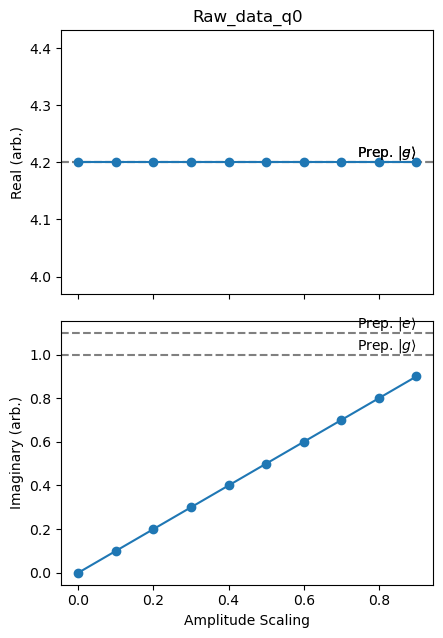

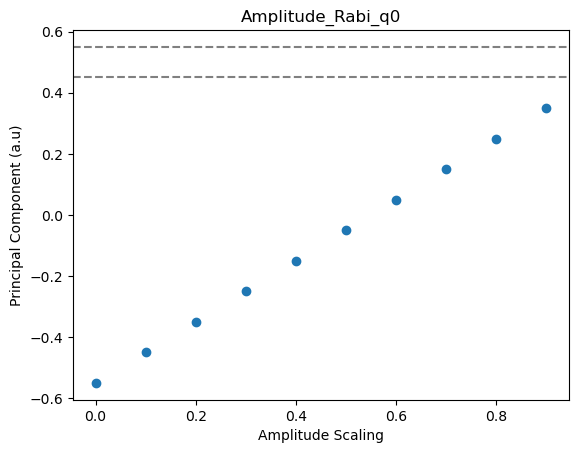

In [53]:
result = rabi_tb.run()
[t.name for t in result.tasks]

Inspect the source code of `create_experiment` to see how the experiment pulse sequence was created.

In [54]:
result.tasks["create_experiment"].src

@task
@qubit_experiment
def create_experiment(
    qpu: QPU,
    qubits: Qubits,
    amplitudes: QubitSweepPoints,
    options: TuneupExperimentOptions | None = None,
) -> Experiment:
    """Creates an Amplitude Rabi experiment Workflow.

    Arguments:
        qpu:
            The qpu consisting of the original qubits and quantum operations.
        qubits:
            The qubits to run the experiments on. May be either a single
            qubit or a list of qubits.
        amplitudes:
            The amplitudes to sweep over for each qubit. If `qubits` is a
            single qubit, `amplitudes` must be a list of numbers or an array. Otherwise
            it must be a list of lists of numbers or arrays.
        options:
            The options for building the experiment.
            See [TuneupExperimentOptions] and [BaseExperimentOptions] for
            accepted options.
            Overwrites the options from [TuneupExperimentOptions] and
            [BaseExperimentOptions].

  

Inspect the LabOne Q Experiment object returned by `create_experiment`

In [55]:
print(result.tasks["create_experiment"].output)
# Or alternatively:
#    print(result.tasks[0].output)

Experiment(
│   uid='create_experiment',
│   name='unnamed',
│   signals={
│   │   '/logical_signal_groups/q0/drive': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/drive',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   │   frequency=1500000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=10,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/drive'
│   │   ),
│   │   '/logical_signal_groups/q0/drive_ef': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/drive_ef',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_ef_osc',
│   │   │   │   │   frequency=200000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   │   frequency=1500000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=10,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/drive_ef'
│   │   ),
│   │   '/logical_signal_groups/q0/measure': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/measure',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_acquire_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   │   frequency=2000000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=5,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/measure'
│   │   ),
│   │   '/logical_signal_groups/q0/acquire': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/acquire',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_acquire_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(

Inspect the LabOne Q CompiledExperiment object returned by `compile_experiment`

In [56]:
print(result.tasks["compile_experiment"].output)

CompiledExperiment(device_setup=DeviceSetup(uid='tunable_transmons_6', servers={'zi_server': DataServer(uid='zi_server', host='localhost', port='8004', api_level=6)}, instruments=[SHFQC(uid='device_shfqc', interface='1GbE', connections=[Connection(direction=IODirection.OUT, local_path=None, local_port='SGCHANNELS/0/OUTPUT', remote_path='/logical_signal_groups/q0/drive', remote_port='0', signal_type=IOSignalType.IQ), Connection(direction=IODirection.OUT, local_path=None, local_port='SGCHANNELS/0/OUTPUT', remote_path='/logical_signal_groups/q0/drive_ef', remote_port='0', signal_type=IOSignalType.IQ), Connection(direction=IODirection.OUT, local_path=None, local_port='QACHANNELS/0/OUTPUT', remote_path='/logical_signal_groups/q0/measure', remote_port='0', signal_type=IOSignalType.IQ), Connection(direction=IODirection.IN, local_path=None, local_port='QACHANNELS/0/INPUT', remote_path='/logical_signal_groups/q0/acquire', remote_port='0', signal_type=IOSignalType.IQ), Connection(direction=IODir

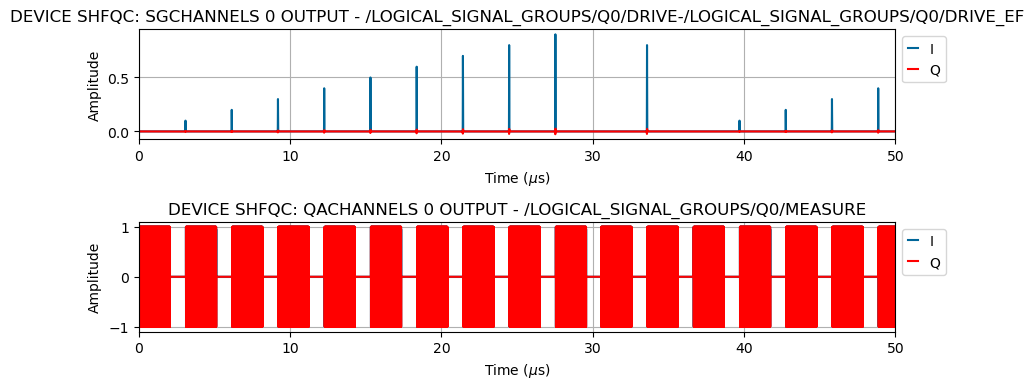

In [57]:
# inspect pulse sequence with plot_simulation
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

plot_simulation(
    result.tasks["compile_experiment"].output,
    signal_names_to_show=["drive", "measure"],
    start_time=0,
    length=50e-6,
)

Inspect the acquired results

In [58]:
acquired_data = result.tasks["run_experiment"].output  # the acquired results
acquired_data

{
│   'errors': [],
│   'neartime_callbacks': {},
│   'cal_trace': {
│   │   'q0': {
│   │   │   'g': AcquiredResult(
│   │   │   │   data=(4.2+1j),
│   │   │   │   axis_name=[],
│   │   │   │   axis=[]
│   │   │   ),
│   │   │   'e': AcquiredResult(
│   │   │   │   data=(4.2+1.1j),
│   │   │   │   axis_name=[],
│   │   │   │   axis=[]
│   │   │   )
│   │   }
│   },
│   'result': {
│   │   'q0': AcquiredResult(
│   │   │   data=array([4.2+0.j , 4.2+0.1j, 4.2+0.2j, 4.2+0.3j, 4.2+0.4j, 4.2+0.5j,
│      4.2+0.6j, 4.2+0.7j, 4.2+0.8j, 4.2+0.9j]),
│   │   │   axis_name=[
│   │   │   │   'amplitude_q0'
│   │   │   ],
│   │   │   axis=[
│   │   │   │   array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
│   │   │   ]
│   │   )
│   }
}

In [59]:
acquired_data.result.q0

AcquiredResult(data=array([4.2+0.j , 4.2+0.1j, 4.2+0.2j, 4.2+0.3j, 4.2+0.4j, 4.2+0.5j,
       4.2+0.6j, 4.2+0.7j, 4.2+0.8j, 4.2+0.9j]), axis_name=['amplitude_q0'], axis=[array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])])

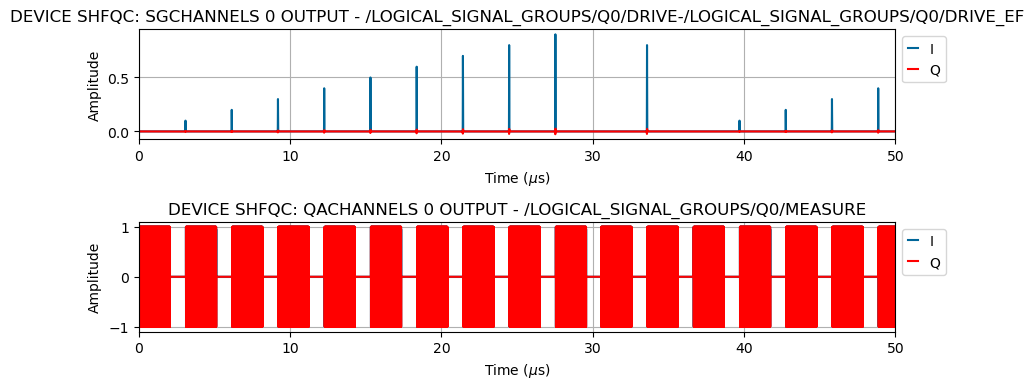

In [60]:
# inspect pulse sequence with plot_simulation
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

plot_simulation(
    result.tasks["compile_experiment"].output,
    signal_names_to_show=["drive", "measure"],
    start_time=0,
    length=50e-6,
)

### Inspect results after an error

If an error occurs during the execution of `amplitude_rabi`, we can inspect the tasks that have run up to the task that produced the error using `recover()`. This is particularly useful to inspect the experiment pulse sequence in case of a compilation or measurement error.

Let's introduce a compilation error by sweeping the ampltude to values larger than 1, which is not allowed.

In [61]:
qop = TunableTransmonOperations()
amplitudes = np.linspace(0.0, 1.5, 10)
options = amplitude_rabi.options()
options.create_experiment.count = 10

# here we catch the exception so that the notebook can keep executing
try:
    rabi_tb = amplitude_rabi.experiment_workflow(
        session,
        qpu,
        qubits[0],
        amplitudes,
        options=options,
    ).run()
except LabOneQException as e:
    print("ERROR: ", e)

[2024.08.30 14:13:06.666] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.30 14:13:06.666] INFO      Workflow 'experiment_workflow': execution started at 2024-08-30               
[2024.08.30 14:13:06.666] INFO      12:13:06.666105Z                                                              
[2024.08.30 14:13:06.685] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.30 14:13:06.685] INFO    Task 'validate_and_convert_qubits_sweeps': started at 2024-08-30 
[2024.08.30 14:13:06.685] INFO    12:13:06.685162Z
[2024.08.30 14:13:06.685] INFO    Task 'validate_and_convert_qubits_sweeps': ended at 2024-08-30 12:13:06.685162Z
[2024.08.30 14:13:06.703] INFO    Task 'create_experiment': started at 2024-08-30 12:13:06.685162Z
rx_pulse_0 1e-07 1.0 False {'beta': 0.01, 'sigma': 0.21}
readout_pulse_0 1e-07 1.0 False {}
integration_kernel_q0_0 2e-06 1.0 False {}
[2024.08.30 14:13:06.708] INFO    Task 'c

[2024.08.30 14:13:06.722] ERROR   Task 'compile_experiment': failed at 2024-08-30 12:13:06.722256Z with: 


[2024.08.30 14:13:06.722] ERROR   LabOneQException("Magnitude of amplitude 1.1666666666666665 exceeding unity for 


[2024.08.30 14:13:06.722] ERROR   LabOneQException("Magnitude of amplitude 1.1666666666666665 exceeding unity for 


[2024.08.30 14:13:06.732] ERROR   pulse 'rx_pulse_0' on signal '/logical_signal_groups/q0/drive' in section 


[2024.08.30 14:13:06.732] ERROR   pulse 'rx_pulse_0' on signal '/logical_signal_groups/q0/drive' in section 


[2024.08.30 14:13:06.732] ERROR   'x180_q0_0'")


[2024.08.30 14:13:06.732] ERROR   'x180_q0_0'")


[2024.08.30 14:13:06.732] INFO    Task 'compile_experiment': ended at 2024-08-30 12:13:06.722256Z
[2024.08.30 14:13:06.732] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.30 14:13:06.732] INFO      Workflow 'experiment_workflow': execution ended at 2024-08-30                 
[2024.08.30 14:13:06.732] INFO      12:13:06.732395Z                                                              
[2024.08.30 14:13:06.732] INFO     ────────────────────────────────────────────────────────────────────────────── 
ERROR:  Magnitude of amplitude 1.1666666666666665 exceeding unity for pulse 'rx_pulse_0' on signal '/logical_signal_groups/q0/drive' in section 'x180_q0_0'


In [62]:
result = amplitude_rabi.experiment_workflow.recover()
result

WorkflowResult(experiment_workflow)

In [63]:
# inspect the experiment section tree
print(result.tasks["create_experiment"].output)

Experiment(
│   uid='create_experiment',
│   name='unnamed',
│   signals={
│   │   '/logical_signal_groups/q0/drive': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/drive',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   │   frequency=1500000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=10,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/drive'
│   │   ),
│   │   '/logical_signal_groups/q0/drive_ef': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/drive_ef',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_ef_osc',
│   │   │   │   │   frequency=200000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   │   frequency=1500000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=10,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/drive_ef'
│   │   ),
│   │   '/logical_signal_groups/q0/measure': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/measure',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_acquire_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   │   frequency=2000000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   mixer_calibration=None,
│   │   │   │   precompensation=None,
│   │   │   │   port_delay=None,
│   │   │   │   port_mode=None,
│   │   │   │   delay_signal=None,
│   │   │   │   voltage_offset=None,
│   │   │   │   range=5,
│   │   │   │   threshold=None,
│   │   │   │   amplitude=None,
│   │   │   │   amplifier_pump=None,
│   │   │   │   added_outputs=None,
│   │   │   │   automute=False
│   │   │   ),
│   │   │   mapped_logical_signal_path='/logical_signal_groups/q0/measure'
│   │   ),
│   │   '/logical_signal_groups/q0/acquire': ExperimentSignal(
│   │   │   uid='/logical_signal_groups/q0/acquire',
│   │   │   calibration=SignalCalibration(
│   │   │   │   oscillator=Oscillator(
│   │   │   │   │   uid='q0_readout_acquire_osc',
│   │   │   │   │   frequency=100000000.0,
│   │   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   │   carrier_type=None
│   │   │   │   ),
│   │   │   │   local_oscillator=Oscillator(

### Run experiment workflow using qubits with temporarily modified parameters

It is possible to run an experiment workflow using qubits with temporarily modified parameters. This is useful for testing or debugging purposes.

To do this, we first clone the qubits from the original qubits and modify the parameters of the cloned qubits.
The experiment workflow is then run using the cloned qubits.

Let's run the amplitude Rabi experiment workflow with a new set of qubits with modified parameters.

[2024.08.30 14:22:09.745] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.30 14:22:09.746] INFO      Workflow 'experiment_workflow': execution started at 2024-08-30               
[2024.08.30 14:22:09.748] INFO      12:22:09.743226Z                                                              
[2024.08.30 14:22:09.749] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2024.08.30 14:22:09.754] INFO    Task 'validate_and_convert_qubits_sweeps': started at 2024-08-30 
[2024.08.30 14:22:09.755] INFO    12:22:09.752918Z
[2024.08.30 14:22:09.758] INFO    Task 'validate_and_convert_qubits_sweeps': ended at 2024-08-30 12:22:09.757921Z
[2024.08.30 14:22:09.765] INFO    Task 'create_experiment': started at 2024-08-30 12:22:09.763329Z
rx_pulse_0 1e-07 1.0 False {'beta': 0.01, 'sigma': 0.21}
readout_pulse_0 1e-07 1.0 False {}
integration_kernel_q0_0 2e-06 1.0 False {}
[2024.08.30 14:22:09.771] INFO    Task 'c

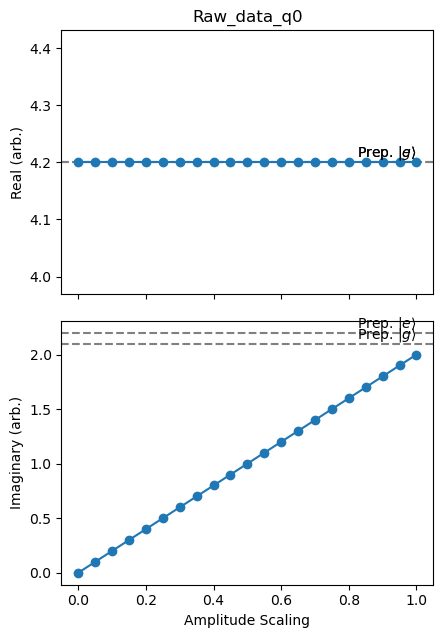

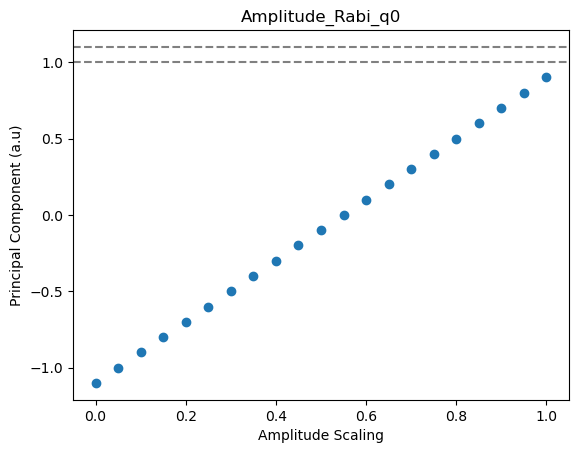

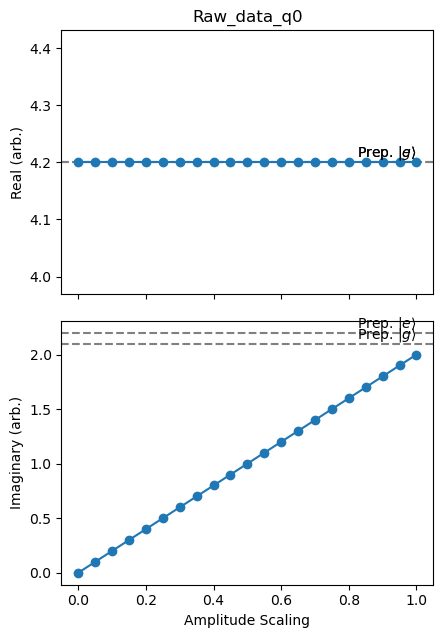

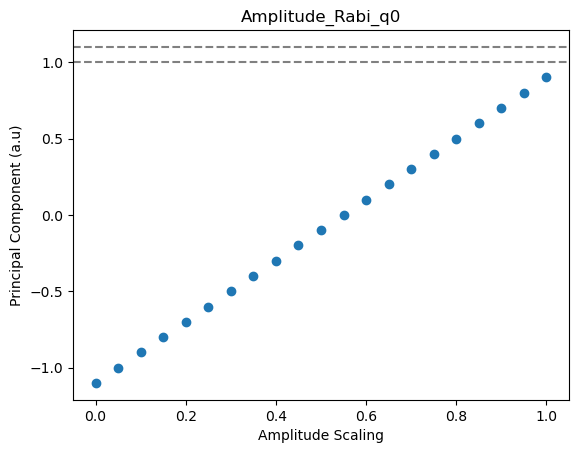

In [66]:
temp_qubits = qpu.copy_qubits()
temp_qubits[0].parameters.ge_drive_length = 1000e-9  # 51ns in the original qubits

result_unmodified = amplitude_rabi.experiment_workflow(
    session,
    qpu,
    qubits[0],  # pass original qubits
    np.linspace(0, 1, 21),
    options=options,
).run()

result_modified = amplitude_rabi.experiment_workflow(
    session,
    qpu,
    temp_qubits[0],  # pass temporary qubits
    np.linspace(0, 1, 21),
    options=options,
).run()

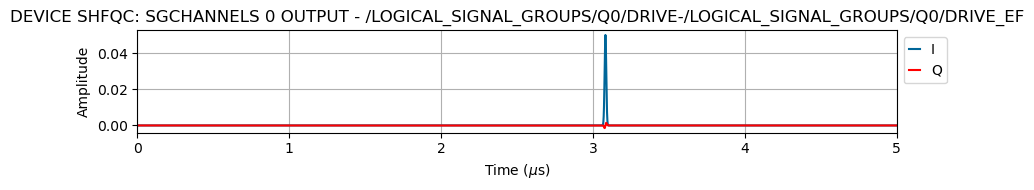

In [67]:
# compare the two pulse sequences
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

plot_simulation(
    result_unmodified.tasks["compile_experiment"].output,
    signal_names_to_show=["drive"],
    start_time=0,
    length=5e-6,
)

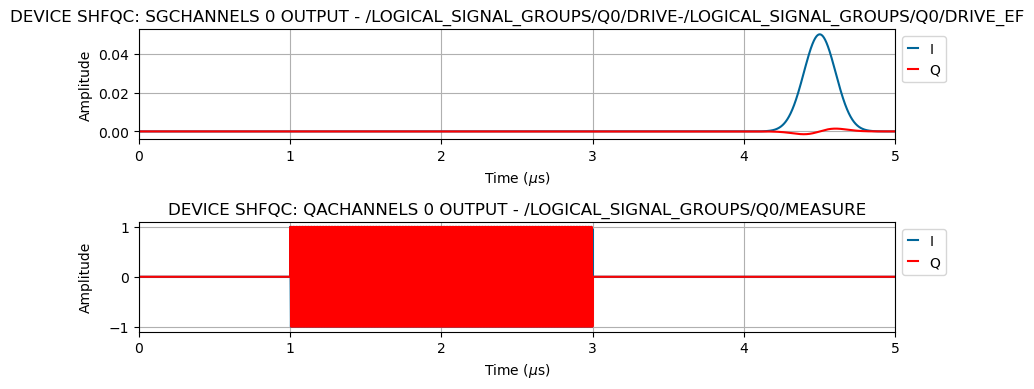

In [68]:
plot_simulation(
    result_modified.tasks["compile_experiment"].output,
    signal_names_to_show=["drive", "measure"],
    start_time=0,
    length=5e-6,
)